In [1]:
# Show plots as part of the notebook (this is a Jupyter-specific operation)
%matplotlib inline
import time
import matplotlib.pyplot as plt
import requests
import xmltodict
# Standard library packages
import os

# Import Pandas and Seaborn
import pandas as pd
import seaborn as sns
import numpy as np

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline

#For execution time tracking
from datetime import datetime
from pytz import timezone

In [2]:
now_time = datetime.now(timezone('America/Chicago'))
print(now_time.strftime('%I:%M:%S %p'))

11:28:49 AM


In [4]:
%%time
df = pd.read_csv('01_db_blastn_Nov112020_filtered_1e-20_95perc-id_subj.csv')

CPU times: user 3.53 s, sys: 307 ms, total: 3.84 s
Wall time: 3.84 s


In [5]:
df['subject'].nunique()

9002

In [6]:
df = df['subject'].value_counts()
df = pd.Series(df)
df

NC_011600.1    44046
EU912438.1     43627
NC_053868.1    25846
MT226925.1     25766
MN121852.1     24049
               ...  
AY626058.1         1
AF289252.1         1
KF744173.1         1
AY308665.1         1
GQ141797.1         1
Name: subject, Length: 9002, dtype: int64

In [7]:
df.to_csv('01_1_Nov112020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy.csv')

In [8]:
df = pd.read_csv('01_1_Nov112020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy.csv')

In [9]:
df.head()

,Unnamed: 0,subject
0,NC_011600.1,44046
1,EU912438.1,43627
2,NC_053868.1,25846
3,MT226925.1,25766
4,MN121852.1,24049


In [10]:
df.columns.values[0] = "subject"
df.columns.values[1] = "count"

In [11]:
df.to_csv('01_1_Nov112020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy.csv', index= False)

In [12]:
df = pd.read_csv('01_1_Nov112020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy.csv')

In [13]:
df.head()

,subject,count
0,NC_011600.1,44046
1,EU912438.1,43627
2,NC_053868.1,25846
3,MT226925.1,25766
4,MN121852.1,24049


# Retrieving (efetch) taxonomy heirarchy from NCBI

In [14]:
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/{}"
db = "nuccore"

In [15]:
def get_taxon_name(tax_id):
    try:
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        Definition = efetch_dict['GBSet']['GBSeq']['GBSeq_definition']
        Definition = Definition.split(',')
        Definition = Definition[0]
        time.sleep(0.5)
    except:
        Definition = tax_id
        pass
 
    return Definition

In [16]:
get_taxon_name ('NC_011600.1')

'Vaucheria litorea chloroplast'

In [17]:
def get_7level_taxonomy(tax_id):
    try:   
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        GBSeq_taxonomy = efetch_dict['GBSet']['GBSeq']['GBSeq_taxonomy']
#        GBSeq_taxonomy_class = GBSeq_taxonomy.split("; ")
#        GBSeq_taxonomy_class = GBSeq_taxonomy_class[2]
        time.sleep(0.5)
    except:
        GBSeq_taxonomy = tax_id
        pass
    
    return GBSeq_taxonomy

In [18]:
get_7level_taxonomy ('NC_011600.1')

'NC_011600.1'

In [19]:
df.head()

,subject,count
0,NC_011600.1,44046
1,EU912438.1,43627
2,NC_053868.1,25846
3,MT226925.1,25766
4,MN121852.1,24049


In [20]:
df['subject']

0       NC_011600.1
1        EU912438.1
2       NC_053868.1
3        MT226925.1
4        MN121852.1
           ...     
8997     AY626058.1
8998     AF289252.1
8999     KF744173.1
9000     AY308665.1
9001     GQ141797.1
Name: subject, Length: 9002, dtype: object

In [21]:
%%time
def enrich_dataset(df):
    taxon_value = df['subject']
    Seven_Level_Taxonomy = get_7level_taxonomy(taxon_value)
    df['7Level_Taxonomy'] = Seven_Level_Taxonomy
    return df

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11.7 µs


In [22]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 5min 39s, sys: 42.7 s, total: 6min 22s
Wall time: 3h 3min 3s


In [23]:
df.to_csv('04_Nov112020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy_enriched.csv', index= False)

# Process Taxonomic Levels, Extract Information¶

In [24]:
df = pd.read_csv('04_Nov112020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy_enriched.csv')

In [25]:
df['7Level_Taxonomy'].nunique()

2677

In [26]:
df.head(5)

,subject,count,7Level_Taxonomy
0,NC_011600.1,44046,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...
1,EU912438.1,43627,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...
2,NC_053868.1,25846,Eukaryota; Sar; Stramenopiles; Stramenopiles i...
3,MT226925.1,25766,Eukaryota; Sar; Stramenopiles; Stramenopiles i...
4,MN121852.1,24049,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...


In [27]:
def taxlevel (tax):
    tax = tax.split("; ")
    tax_len = len(tax)
    
    return tax_len

In [28]:
def enrich_dataset(df):
    taxon_level = df['7Level_Taxonomy']
    Seven_Level_Taxonomy = taxlevel(taxon_level)
    df['7Level_Lenght'] = Seven_Level_Taxonomy
    return df

In [29]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 1.25 s, sys: 9.36 ms, total: 1.25 s
Wall time: 1.25 s


In [30]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght
0,NC_011600.1,44046,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9
1,EU912438.1,43627,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9
2,NC_053868.1,25846,Eukaryota; Sar; Stramenopiles; Stramenopiles i...,5
3,MT226925.1,25766,Eukaryota; Sar; Stramenopiles; Stramenopiles i...,5
4,MN121852.1,24049,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9


In [31]:
df['7Level_Lenght'].value_counts()

1     1985
2     1694
6     1516
9      875
8      681
4      680
7      482
10     394
5      268
3      250
11     177
Name: 7Level_Lenght, dtype: int64

In [32]:
df.shape

(9002, 4)

In [33]:
df["Levels"] = df["7Level_Lenght"].replace({11: "11_Levels",
                                           10: "10_Levels",
                                           9: "9_Levels",
                                           8: "8_Levels",
                                           7: "7_Levels",
                                           6: "6_Levels",
                                           5: "5_Levels",
                                           4: "4_Levels",
                                           3: "3_Levels",
                                           2: "2_Levels",
                                           1: "1_Level",
                                           })

In [34]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght,Levels
0,NC_011600.1,44046,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9,9_Levels
1,EU912438.1,43627,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9,9_Levels
2,NC_053868.1,25846,Eukaryota; Sar; Stramenopiles; Stramenopiles i...,5,5_Levels
3,MT226925.1,25766,Eukaryota; Sar; Stramenopiles; Stramenopiles i...,5,5_Levels
4,MN121852.1,24049,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9,9_Levels


<AxesSubplot:>

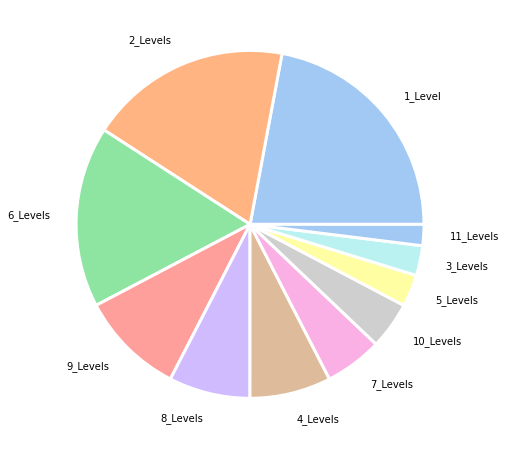

In [35]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='')

<AxesSubplot:>

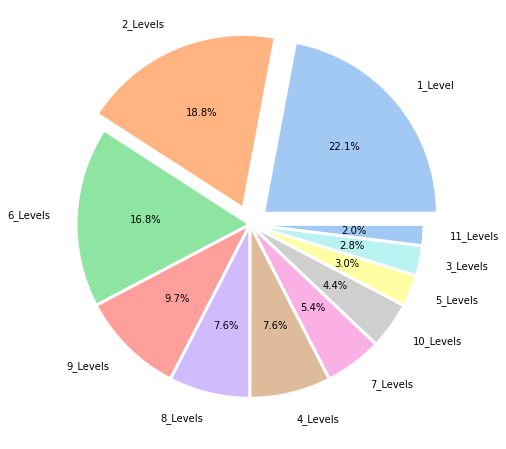

In [36]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='',
                                     autopct='%1.1f%%',
                                    explode = explode)

<AxesSubplot:>

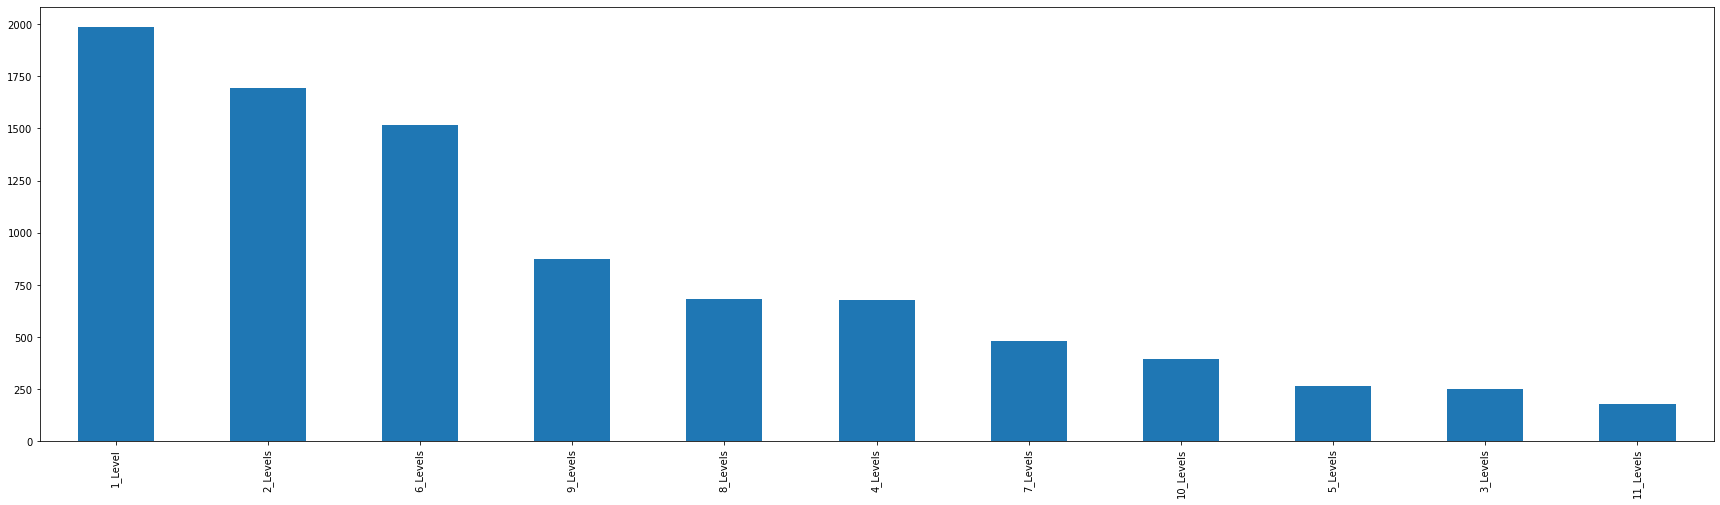

In [37]:
df['Levels'].value_counts().plot.bar()

##### Saving the count of taxonomic levels of each subject (blasted accession numbers from Nucleotide database of NCBI)¶

In [38]:
df.to_csv('05_Nov112020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy_enriched.csv', index= False)